## First look at UGC993

Finding emission lines and calculating redshift

In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import specutils
import astropy.units as u

from astropy.io import fits

from specutils import Spectrum1D, SpectralRegion
from specutils import SpectralRegion
from specutils.fitting import estimate_line_parameters
from specutils.manipulation import extract_region
from specutils.fitting import fit_lines
from astropy.nddata import StdDevUncertainty
from specutils.fitting import find_lines_threshold

from astropy.modeling import models

In [2]:
ugc993 = fits.open('UGC993.fits')

In [3]:
header = ugc993[1].header
header

XTENSION= 'IMAGE   '           / IMAGE extension                                
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    3 / number of data axes                            
NAXIS1  =                  322 / length of data axis 1                          
NAXIS2  =                  323 / length of data axis 2                          
NAXIS3  =                 3801 / length of data axis 3                          
PCOUNT  =                    0 / required keyword; must = 0                     
GCOUNT  =                    1 / required keyword; must = 1                     
EXTNAME = 'DATA    '           / This extension contains data values            
HDUCLASS= 'ESO     '           / class name (ESO format)                        
HDUDOC  = 'DICD    '           / document with class description                
HDUVERS = 'DICD version 6'     / version number (according to spec v2.5.1)      
HDUCLAS1= 'IMAGE   '        

In [4]:
wavelength = np.arange(header['CRVAL3'], header['CRVAL3'] + header['CD3_3'] * header['NAXIS3'], header['CD3_3'])

fluxCube = ugc993[1].data
errorCube = ugc993[2].data

In [5]:
whiteImage = np.nansum(fluxCube, axis=0)

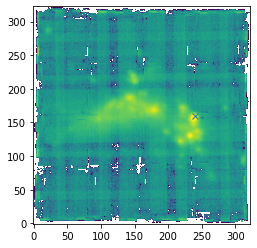

In [6]:
plt.imshow(whiteImage, origin='lower', norm=mpl.colors.LogNorm(vmin=100, vmax=1e5));

plt.plot(240, 160, 'x')

# plt.ylim(100, 200)
# plt.xlim(100, 200);

Text(0.5, 1.0, 'Noise over 10 pixels')

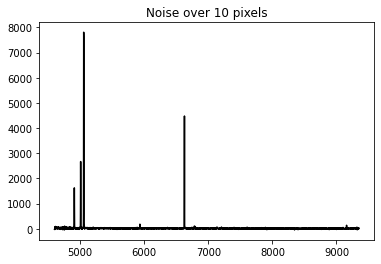

In [7]:
plt.plot(wavelength, fluxCube[:, 160, 240], 'k-');
#plt.xlim(6521.03515625, 6533.53515625)
plt.title('Noise over 10 pixels')


#print(np.mean(fluxCube[1417:1427, 160, 240]))


#### From SDSS:

H Beta - 4862.68

O III - 4960.295

O III - 5008.240

H alpha - 6564.61

In [8]:
#Wavelengths = [H beta, O III, O III, H alpha]
labs = np.array([4862.68, 4960.295, 5008.240, 6564.61])


In [9]:
def redshift(lab, observed):
    '''
    Function to calculate redshift
    '''
    return (observed - lab)/lab

(6600.0, 6700.0)

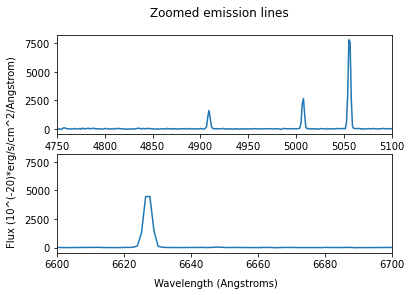

In [10]:
fig, (ax1, ax2) = plt.subplots(2)

fig.suptitle('Zoomed emission lines')

fig.text(0.35, 0.01, 'Wavelength (Angstroms)')
fig.text(0.01, 0.15, 'Flux (10^(-20)*erg/s/cm^2/Angstrom)', rotation='vertical')

ax1.plot(wavelength, fluxCube[:, 160, 240])
ax1.set_xlim(4750, 5100)
ax2.plot(wavelength, fluxCube[:, 160, 240])
ax2.set_xlim(6600, 6700)

# Specutils

Need to redefine the spectra in terms of specutils/astropy quantities

In [11]:
lamb = wavelength * u.AA 
flux = fluxCube[:, 160, 240]* 10**-20 * u.Unit('erg cm-2 s-1 AA-1')

spec = Spectrum1D(spectral_axis = lamb, flux=flux, 
                  uncertainty = StdDevUncertainty(np.sqrt(errorCube[:, 160, 240])* 10**-20))

print(spec.shape)

(3801,)


(6000.0, 7000.0)

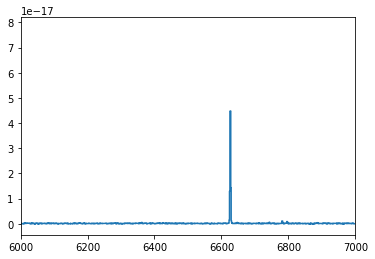

In [12]:
f, ax = plt.subplots()  

ax.step(spec.spectral_axis, spec.flux) 

ax.set_xlim(6000, 7000)

# Searching for lines with specutils

In [13]:
lines = find_lines_threshold(spec, noise_factor= 20)  
#lines = find_lines_threshold(spec, flux_threshold=0.25)

#lines[lines['line_type'] == 'emission']  

lines


If you want to suppress this warning either type 'specutils.conf.do_continuum_function_check = False' or see http://docs.astropy.org/en/stable/config/#adding-new-configuration-items for other ways to configure the warning. [specutils.analysis.flux]


line_center,line_type,line_center_index
Angstrom,,
float64,str8,int64
4909.02001953125,emission,247
5007.77001953125,emission,326
5055.27001953125,emission,364
6627.77001953125,emission,1622


In [14]:
spec_obs = lines['line_center']#[0]

spec_redshift = redshift(labs*u.AA, spec_obs)

print(spec_redshift)
print(f'Mean calculated redshift: {np.mean(spec_redshift)}')


[0.00952973 0.00957101 0.00939053 0.00962129]
Mean calculated redshift: 0.00952813860282882


In [15]:
print(wavelength[1622])

6627.77001953125


###### Find and subtract noise 

no lines between 10 angstrom range:

indices 1400, 1470

wavelength 6350 6440


In [16]:
halphaNoise = (fluxCube[1605:1615])


(323, 322)


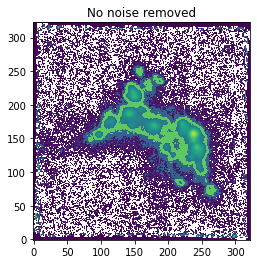

In [19]:
halphaImage = np.nansum(fluxCube[1617:1627], axis=0)
print(halphaImage.shape)

plt.imshow(halphaImage, origin='lower', norm=mpl.colors.LogNorm(vmin=10, vmax=1e5));
plt.title('No noise removed')
plt.contourf(halphaImage, levels=[50, 75, 150, 250])



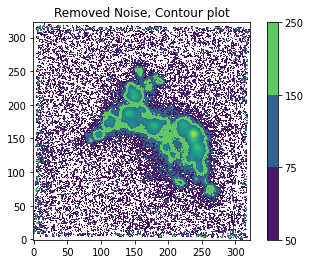

In [20]:
#Removing background noise from spectrum

HalphaImage = np.nansum((fluxCube[1617:1627] - halphaNoise), axis=0)

plt.title('Removed Noise, Contour plot')
plt.imshow(HalphaImage, origin='lower', norm=mpl.colors.LogNorm(vmin=10, vmax=1e5));

plt.contourf(HalphaImage, levels=[50, 75, 150, 250])
plt.colorbar()

#### Masked cubes

In [21]:
Flux250 = fluxCube[:, np.array(np.where(HalphaImage >= 250))[0], np.array(np.where(HalphaImage >= 250))[1]]
Flux75 = fluxCube[:, np.array(np.where(HalphaImage >= 75))[0], np.array(np.where(HalphaImage >= 75))[1]]
#Flux10 = fluxCube[:, np.array(np.where(HalphaImage >= 10))[0], np.array(np.where(HalphaImage >= 10))[1]]

In [22]:
#230, 150
np.array(np.where(HalphaImage >= 75)).shape

(2, 13788)

In [ ]:
x = (np.where((np.where(HalphaImage>=75))[1]==150))
y = (np.where((np.where(HalphaImage >= 75))[0]==230))

print(x)
print(y)

In [ ]:
print((np.where(HalphaImage >= 75))[1][12842])
print((np.where(HalphaImage >= 75))[0][12842])

In [23]:
print(Flux250.shape)
print(Flux75.shape)
#print(Flux10.shape)

(3801, 5130)
(3801, 13788)


In [24]:
#plt.plot(wavelength, fluxCube[:, (np.where(HalphaImage >= 100))[0][7134], (np.where(HalphaImage >= 100))[1][7134]])
#plt.plot(wavelength, Flux100[:, 7134])

In [25]:
Error250 = errorCube[:, np.array(np.where(HalphaImage >= 250))[0], np.array(np.where(HalphaImage >= 250))[1]]
Error75 = errorCube[:, np.array(np.where(HalphaImage >= 75))[0], np.array(np.where(HalphaImage >=75))[1]]
#Error10 = errorCube[:, np.array(np.where(HalphaImage >= 10))[0], np.array(np.where(HalphaImage >= 10))[1]]

Can now start trying to fit for the masked values

## Question

am I fitting gaussian to the 10 pixel length?

Text(0.5, 1.0, 'H-alpha line, 10 pixels')

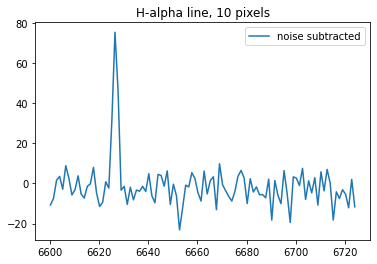

In [26]:
plt.plot(wavelength[1600:1700], fluxCube[1600:1700, 230, 150] - np.mean(halphaNoise[:, 230, 150]), label='noise subtracted')
#plt.plot(wavelength[1600:1700], fluxCube[1600:1700, 230, 150], label='raw data')
#plt.xlim(6500.78515625, 6600.03515625)
#plt.ylim(-500, 500)
plt.legend()
plt.title('H-alpha line, 10 pixels')


Try fitting individual line 

In [27]:
print(wavelength[1600])
print(wavelength[1680])

6600.27001953125
6700.27001953125


0.003204040804511799
estimate: Model: Gaussian1D
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
          amplitude               mean        stddev 
    erg / (Angstrom cm2 s)      Angstrom     Angstrom
    ---------------------- ----------------- --------
         78.63239464858677 6626.689200556948      nan
NAN
Model amplitude: 82.25279411439092
Model mean: 6626.666540849239


/home/s1929920/.conda/envs/CP_env/lib/python3.7/site-packages/astropy/units/quantity.py:479: RuntimeWarning: invalid value encountered in sqrt
  result = super().__array_ufunc__(function, method, *arrays, **kwargs)


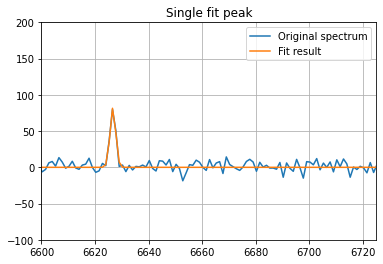

In [33]:
from astropy.modeling import models, fitting
from specutils.fitting import fit_continuum


if str(np.float64(fluxCube[1625:1650, 230, 150].max())) == 'nan':
    centre_pixel = np.array([1631]),
    print('NAN')
else:
    centre_pixel = (np.where(fluxCube[:, 230, 150] == fluxCube[1625:1650, 230, 150].max()))

#print(centre_pixel)
centre = int(np.float64(centre_pixel[-1]))

redshift_estimate = redshift(labs[-1], wavelength[int(np.float64(centre_pixel[-1]))])
#print(f'redshift estimate: {redshift_estimate}')
#print(f'integer value of max peak: {centre}')


# Model H alpha line using Gaussian 1D
#=======================================================================
#should spectrum be only 10 pixel range? Probably not, need to model continuum too. Say 50 each side
spectrum = Spectrum1D(flux = fluxCube[centre-50:centre+50, 230, 150]*u.Unit('erg cm-2 s-1 AA-1'),
            spectral_axis=wavelength[centre-50:centre+50]*u.AA)

#print(f'spectrum: {spectrum}')
sub_region = SpectralRegion(6620*u.AA, 6635*u.AA)

sub_spectrum = extract_region(spectrum, sub_region)
#print(f'sub spectrum: {sub_spectrum}')


c_init = fit_continuum(spectrum, model = models.Polynomial1D(1, c0=6.51286088, c1=0),
                       window=[(6560*u.AA, 6620*u.AA), (6650*u.AA, 6700*u.AA)])
c_model = c_init(wavelength[centre-50:centre+50]*u.AA)

print(np.float64(c_init.c1))

sub_spectrum = extract_region(spectrum - c_model, sub_region)

estimate = (estimate_line_parameters(sub_spectrum, models.Gaussian1D()))
    

print(f'estimate: {estimate}')

if str(np.float64(estimate.stddev)) == 'nan':
    print('NAN')
    g_init = models.Gaussian1D(amplitude=np.float64(estimate.amplitude),
                       mean=np.float64(estimate.mean), stddev=1*u.AA)
else:
    print(f'standard deviation: {np.float64(estimate.stddev)}')
    g_init = models.Gaussian1D(amplitude=np.float64(estimate.amplitude),
                       mean=np.float64(estimate.mean), stddev=np.float64(estimate.stddev))


g_fit = fit_lines(spectrum, g_init,
                  window=[(6620*u.AA, 6640*u.AA)])
y_fit = g_fit(wavelength*u.AA)
print(f'Model amplitude: {np.float64(g_fit.amplitude)}')
print(f'Model mean: {np.float64(g_fit.mean)}')

plt.plot(wavelength, fluxCube[:, 230, 150], label="Original spectrum")
plt.plot(wavelength, y_fit, label="Fit result")
plt.title('Single fit peak')
plt.xlim(6600, 6725)
plt.grid(True)

plt.ylim(-100, 200)
plt.legend()


In [29]:
sub_region = SpectralRegion(6600*u.AA, 6700*u.AA)

sub_spectrum = extract_region(spectrum, sub_region)

#print(estimate_line_parameters(sub_spectrum, models.Gaussian1D()))

estimates = (estimate_line_parameters(sub_spectrum, models.Gaussian1D()))

print(np.float64(estimates.amplitude))

print(estimates.amplitude)
print(estimates.mean)
print(estimates.stddev)



79.81246948242188
Parameter('amplitude', value=79.81246948242188, unit=erg / (Angstrom cm2 s))
Parameter('mean', value=6632.891788404688, unit=Angstrom)
Parameter('stddev', value=18.48246685563388, unit=Angstrom, bounds=(1.1754943508222875e-38, None))


## Function

Use contour lines H alpha to get pixels that will be used in an array

input array wavelength, flux

In function:

Plot spectrum

Find lines

Calculate redshift

Fit lines

Plot fitted with spectrum, save values


In [34]:
def function(wavelength, fluxMask, error):
    '''
    Function to fit H alpha lines
    :param wavelength: array of shape (3801,) of wavelengths over spectrum, units Angstrom
    :param fluxMask: fluxes for spaxels where Flux > value
    :param error: error on fluxes for masked spaxels
    :return amplitude: amplitude of Gaussian for fitted H alpha emission line
    :param mean: centre wavelength of peak 
    :param stddev: standard deviation, or width of line
    :param redshift_value: calculated redshift using param mean and lab observed H alpha wavelength 
    '''
    #print(f'number of pixels: {len(fluxMask)}')
    #length = len(fluxMask)
    # Write spectrum astropy way and plot spectrum
    #=======================================================================
    specutils.conf.do_continuum_function_check = False
    
    lamb = wavelength * u.AA 
    fluxData = fluxMask * u.Unit('erg cm^-2 s^-1 AA^-1')
    spec = Spectrum1D(spectral_axis = lamb, flux=fluxData, 
                  uncertainty = StdDevUncertainty(np.sqrt(error)* 10**-20))
    
    f, ax = plt.subplots()  

    ax.step(spec.spectral_axis, (spec.flux))
    ax.set_xlim(6500, 6700)
    
    # Find lines and calculate redshift
    #========================================================================
    lines = find_lines_threshold(spec, noise_factor = 50)  
    
    spec_obs = lines['line_center'][lines['line_type'] == 'emission']
    
    #if len(spec_obs)==4:
        #spec_redshift = redshift(labs*u.AA, spec_obs)
        #print(f'Mean calculated redshift: {np.mean(spec_redshift)}')
        
    if len(spec_obs) == 0:
        print(f'No lines found')
        
    #else:
        #print(f'{len(spec_obs)} lines found')
        #print(spec_obs)
        
    #print(f'flux shape: {fluxData.shape}')
    
    # Find centre pixel of H alpha line
    #=======================================================================
    if str(np.float64(fluxData[1625:1650].max())) == 'nan':
        centre_pixel = np.array([1631]),
        print('NAN')
    else:
        centre_pixel = (np.where(fluxData == fluxData[1625:1650].max()))
    
    print(centre_pixel)
    centre = int(np.float64(centre_pixel[-1]))
    
    redshift_estimate = redshift(labs[-1], wavelength[int(np.float64(centre_pixel[-1]))])
    #print(f'redshift estimate: {redshift_estimate}')
    #print(f'integer value of max peak: {centre}')
    
    
    # Model H alpha line using Gaussian 1D
    #=======================================================================
    #should spectrum be only 10 pixel range? Probably not, need to model continuum too. Say 50 each side
    spectrum = Spectrum1D(flux =
                fluxData[centre-50:centre+50],
                spectral_axis=wavelength[centre-50:centre+50]*u.AA)

    #print(f'spectrum: {spectrum}')
    sub_region = SpectralRegion(6620*u.AA, 6635*u.AA)

    sub_spectrum = extract_region(spectrum, sub_region)
    #print(f'sub spectrum: {sub_spectrum}')
    
        
    c_init = fit_continuum(spectrum, model = models.Polynomial1D(1, c0=6.51286088, c1=0),
                           window=[(6560*u.AA, 6620*u.AA), (6650*u.AA, 6700*u.AA)])
    
    c_model = c_init(wavelength[centre-50:centre+50]*u.AA)
    
    sub_spectrum = extract_region(spectrum - c_model, sub_region)
    
    estimate = (estimate_line_parameters(sub_spectrum, models.Gaussian1D()))
    #print(f'estimate: {str(np.float64(estimate.stddev))}')
    #print(f'estimate: {(np.float64(estimate.amplitude))}')
    #print(f'estimate: {estimate}')
    
    
    #if (np.float64(estimate.amplitude)) <= 0:
        #print(f'no amplitude found')
        #g_init = models.Gaussian1D(amplitude = 20*u.Unit('erg cm^-2 s^-1 AA^-1'),
        #                          mean=np.float64(estimate.mean), stddev=1*u.AA)
        
    if str(np.float64(estimate.stddev)) == 'nan':
        #print('NAN')
        g_init = models.Gaussian1D(amplitude=np.float64(estimate.amplitude),
                           mean=np.float64(estimate.mean), stddev=1*u.AA)
    else:
        #print(f'standard deviation: {np.float64(estimate.stddev)}')
        g_init = models.Gaussian1D(amplitude=np.float64(estimate.amplitude),
                           mean=np.float64(estimate.mean), stddev=np.float64(estimate.stddev))
            
    g_fit = fit_lines(spectrum, g_init,
                      window=[(6620*u.AA, 6630*u.AA)])
    y_fit = g_fit(wavelength*u.AA)
    
    #print(f'Model amplitude: {np.float64(g_fit.amplitude)}')
    #print(f'Model mean: {np.float64(g_fit.mean)}')
    
    redshift_value = redshift(labs[-1], np.float64(g_fit.mean))
    #print(f'redshift value: {redshift_value}')
    
    # Plot the original spectrum and the fitted.
    #=======================================================================
    
    plt.plot(wavelength, fluxData, label="Original spectrum")
    #plt.plot(wavelength[centre-50:centre+50],
    #         flux[centre-50:centre+50], label='test emission line')
    plt.plot(wavelength, y_fit, label="Fit result")
    plt.title('Single fit peak')
    #plt.xlim(6500, 6650)
    #plt.ylim(0, 300)
    plt.grid(True)
    plt.legend()
    
    # Save Parameters
    #=============================================================================
    amplitude = np.float64(g_fit.amplitude)
    mean = np.float64(g_fit.mean)
    stddev = np.float64(g_fit.stddev)
    c_0 = np.float64(c_init.c0)
    c_1 = np.float64(c_init.c1)
    
    return c_0, c_1, amplitude, mean, stddev, redshift_value

    
    
    
    

In [ ]:
def model(lambda_, c0, c1, A, mu, sigma):
    '''
    Function to plot model of emission line, continuum and gaussian
    So we can check residuals of the brightest spaxels
    :param lambda_: wavelength
    :param c0: y-intercept of continuum
    :param c1: gradient of continuum
    :param A: amplitude of gaussian
    :param mu: mean of gaussian
    :param sigma: standard deviation of gaussian
    :returns y: y = c0 + c1*x + Aexp(-(x-mu)^2/(2*sigma^2))
    '''
    y = c0 + c1*lambda_ + A*np.exp(-(lambda_ - mu)**2/(2*sigma**2))
    return y

(3801,)
(array([1647]),)


(-147.31010354389886,
 0.022923286522395163,
 193.4909704580263,
 6626.490228269653,
 1.1434809384957583,
 0.009426337325393793)

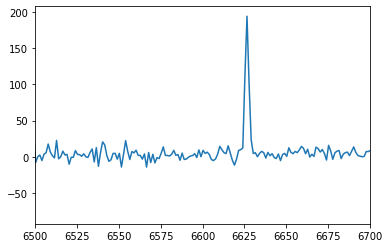

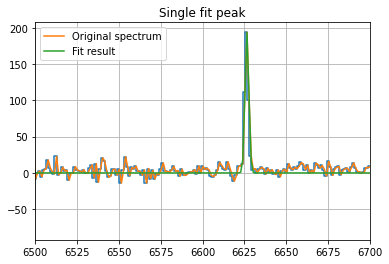

In [35]:
print(wavelength.shape)
#3155 3365
plt.plot(wavelength, Flux250[:, 3155+18])
#plt.axvline(6623, 0, 1, linestyle = 'dotted')
#plt.axvline(6635, 0, 1, linestyle = 'dotted')
#plt.axhline(14.8, 0, 1, linestyle = 'dotted')
plt.xlim(6500, 6700)
#plt.ylim(0, 150)

function(wavelength, (Flux250[:, 3155+18]), (Error250[:, 3155+18]))

In [ ]:
print(len(Flux250))

# Flux > 250

In [ ]:
import warnings

warnings.filterwarnings("ignore", message="[astropy.modeling.fitting]")

amplitudes_list = np.zeros(5058-18)
mean_list = np.zeros(5058-18)
stddev_list = np.zeros(5058-18)
red_list = np.zeros(5058-18)

# Try running loop of 10 pixels
for i in range(18, 5058):
    amplitudes_list[i-18], mean_list[i-18], stddev_list[i-18], red_list[i-18] = function(wavelength, (Flux250[:, i]), (Error250[:, i]))
    
    
    
    

In [ ]:
amp_array = np.zeros((HalphaImage).shape)
red_array = np.zeros((HalphaImage).shape)
std_array = np.zeros((HalphaImage).shape)
mean_array = np.zeros((HalphaImage).shape)

for i in range(5040):
    amp_array[(np.where(HalphaImage>=250))[0][i+18], (np.where(HalphaImage>=250))[1][i+18]] = amplitudes_list[i]
    red_array[(np.where(HalphaImage>=250))[0][i+18], (np.where(HalphaImage>=250))[1][i+18]] = red_list[i]
    std_array[(np.where(HalphaImage>=250))[0][i+18], (np.where(HalphaImage>=250))[1][i+18]] = stddev_list[i]
    mean_array[(np.where(HalphaImage>=250))[0][i+18], (np.where(HalphaImage>=250))[1][i+18]] = mean_list[i]
    



In [37]:
print(len(np.where(HalphaImage>=75)[0]))

13788


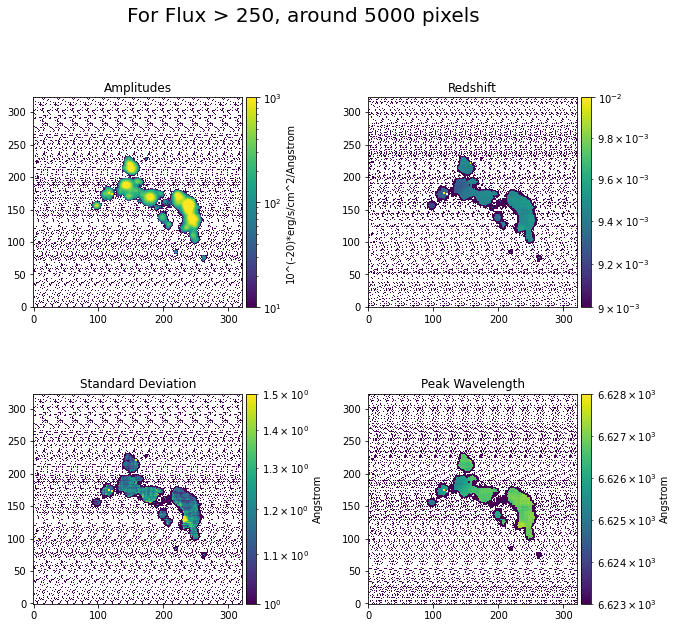

In [409]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, axs = plt.subplots(2, 2, figsize = (10, 10))
fig.suptitle('For Flux > 250, around 5000 pixels', fontsize=20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.2)

#-------------------------------------------------------------------------------------------
im1 = axs[0, 0].imshow(amp_array,  origin='lower', norm=mpl.colors.LogNorm(vmin=10, vmax=1e3))
axs[0, 0].set_title('Amplitudes')

divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label='10^(-20)*erg/s/cm^2/Angstrom')

#-------------------------------------------------------------------------------------------
im2 = axs[0, 1].imshow(red_array,  origin='lower', norm=mpl.colors.LogNorm(vmin=0.0090, vmax=0.01))
axs[0, 1].set_title('Redshift')

divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

#-------------------------------------------------------------------------------------------
im3 = axs[1, 0].imshow(std_array,  origin='lower', norm=mpl.colors.LogNorm(vmin=1, vmax=1.5))
axs[1, 0].set_title('Standard Deviation')

divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical', label='Angstrom');

#-------------------------------------------------------------------------------------------
im4 = axs[1, 1].imshow(mean_array,  origin='lower', norm=mpl.colors.LogNorm(vmin=6623, vmax=6628))
axs[1, 1].set_title('Peak Wavelength')

divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical', label='Angstrom');

why is it upside down?

In [36]:
def velocity_calc(lambda_):
    '''
    Function to calculate velocity, using peak wavelength
    '''
    return 3e5 * (lambda_ - 6563)/6563

def sigma_calc(std_dev):
    '''
    Function to calculate sigma, with instrument error removed
    sigma_obs^2 = sigma_real^2 + sigma_instrument^2
    '''
    #check whether instrument sigma^2 = 1
    return 3e5 * (np.sqrt(std_dev**2-1**2)/6563) 

In [ ]:
velocities = velocity_calc(mean_array)

In [ ]:
print(np.nanmedian(velocities[velocities>0]))
print(velocities.min())

In [ ]:
plt.imshow(velocities,  origin='lower', norm=mpl.colors.Normalize(vmin=2800, vmax=3000))

In [ ]:
sigmas = sigma_calc(std_array) #correct for instrument

In [ ]:
print(np.nanmedian(sigmas[sigmas>0]))
print(sigmas.min())

In [ ]:
plt.imshow(sigmas,  origin='lower', norm=mpl.colors.Normalize(vmin=10, vmax=60))
plt.colorbar()

In [ ]:
print(amplitudes_list.shape)
#Don't want to include high redshifts, too high std devs, any where the mean is zero in averages

print(np.where(red_list>=0.012))
print(np.where(stddev_list >= 5))
print(np.where(mean_list <= 6620))

In [330]:
print('DISCARDING BAD FITS')
print(f'mean peak wavelength: {np.mean(mean_list[np.r_[0:51, 53:3154, 3156:3364, 3366:4881, 4883:4903, 4906:5009]])} Angstrom')

print(f'mean redshift: {np.mean(red_list[np.r_[0:51, 53:3154, 3156:3364, 3366:4881, 4883:4903, 4906:5009]])}')

print(f'mean std dev: {np.mean(stddev_list[np.r_[0:51, 53:3154, 3156:3364, 3366:4881, 4883:4903, 4906:5009]])} Angstrom')

DISCARDING BAD FITS
mean peak wavelength: 6626.508914566971 Angstrom
mean redshift: 0.009429183845951504
mean std dev: 1.2142304873215377 Angstrom


In [368]:
# Keep track of brightest pixels:

#(np.where(amplitudes_list >= 700))
idx = (-amplitudes_list).argsort()[:10]
print(f'10 brightest pixels: {idx}')

print(amplitudes_list[1844])


10 brightest pixels: [3155 3365 1844 1845 1772 1843 1773 1771 1914 1704]
17407.65813104323


In [ ]:
fig, axs = plt.subplots(5, 2, figsize = (10, 15))

axs[0, 0].plot(wavelength, Flux250[:, idx[0]+18])
axs[0, 1].plot(wavelength, Flux250[:, idx[1]+18])
axs[1, 0].plot(wavelength, Flux250[:, idx[2]+18])
axs[1, 1].plot(wavelength, Flux250[:, idx[3]+18])
axs[2, 0].plot(wavelength, Flux250[:, idx[4]+18])
axs[2, 1].plot(wavelength, Flux250[:, idx[5]+18])
axs[3, 0].plot(wavelength, Flux250[:, idx[6]+18])
axs[3, 1].plot(wavelength, Flux250[:, idx[7]+18])
axs[4, 0].plot(wavelength, Flux250[:, idx[8]+18])
axs[4, 1].plot(wavelength, Flux250[:, idx[9]+18])

# Results

In [205]:
print(amplitudes_list[np.where(stddev_list>=3)], mean_list[np.where(stddev_list>=3)], stddev_list[np.where(stddev_list>=3)], red_list[np.where(stddev_list>=3)])
print(np.mean(red_list))
print(np.mean(stddev_list))
#print(np.mean(amplitudes_list))
print(np.mean(mean_list))

[50.37178954 89.72185059 33.89759452] [6627.7179855  6626.8777408  6628.73028828] [3.15607627 3.46090862 3.5639616 ] [0.00961336 0.00948537 0.00976757]
0.00942919013059442
1.21416859424177
6626.508955823201


In [ ]:
# change function to save c0, c1



# Flux > 75, 13788 spaxels

In [ ]:
import warnings

warnings.filterwarnings("ignore", message="[astropy.modeling.fitting]")


amplitudes75 = np.zeros(13788)
mean75 = np.zeros(len(amplitudes75))
stddev75 = np.zeros(len(amplitudes75))
red75 = np.zeros(len(amplitudes75))
c0_75 = np.zeros(len(amplitudes75))
c1_75 = np.zeros(len(amplitudes75))

#all spaxels
for i in range(0, len(amplitudes75)):
    c0_75[i], c1_75[i], amplitudes75[i], mean75[i], stddev75[i], red75[i] = function(wavelength, (Flux75[:, i]), (Error75[:, i]))
    

    
    
    

(array([1642]),)
(array([1632]),)
(array([1625]),)
(array([1631]),)
(array([1627]),)
(array([1627]),)
(array([1643]),)
(array([1633]),)
(array([1627]),)
(array([1643]),)
(array([1632]),)
(array([1641]),)
(array([1641]),)
(array([1641]),)
(array([1636]),)
(array([1632]),)
(array([1649]),)
(array([1649]),)
NAN
(array([1631]),)
(array([1626]),)
(array([1626]),)
(array([1636]),)
(array([1645]),)
(array([1628]),)
(array([1627]),)
(array([1626]),)
(array([1638]),)
(array([1637]),)
(array([1640]),)
(array([1636]),)
(array([1640]),)
(array([1643]),)
(array([1637]),)
(array([1639]),)
(array([1644]),)
(array([1641]),)
(array([1626]),)
(array([1632]),)
(array([1628]),)
(array([1641]),)
(array([1626]),)
NAN
(array([1631]),)
(array([1646]),)
(array([1640]),)
(array([1627]),)
(array([1648]),)
(array([1625]),)
(array([1646]),)
(array([1628]),)
(array([1649]),)
(array([1637]),)
(array([1639]),)
(array([1649]),)
(array([1635]),)
(array([1630]),)
(array([1641]),)
(array([1649]),)
(array([1648]),)
(array

(array([1634]),)
(array([1629]),)
(array([1638]),)
(array([1636]),)
(array([1625]),)
(array([1640]),)
(array([1642]),)
(array([1635]),)
(array([1638]),)
(array([1626]),)
(array([1629]),)
(array([1646]),)
(array([1626]),)
(array([1632]),)
(array([1636]),)
(array([1636]),)
(array([1635]),)
(array([1638]),)
(array([1626]),)
(array([1626]),)
(array([1637]),)
(array([1629]),)
(array([1636]),)
(array([1635]),)
(array([1642]),)
(array([1637]),)
(array([1626]),)
(array([1648]),)
(array([1625]),)
(array([1626]),)
(array([1636]),)
(array([1636]),)
(array([1634]),)
(array([1626]),)
(array([1638]),)
(array([1632]),)
(array([1631]),)
(array([1644]),)
(array([1625]),)
(array([1628]),)
(array([1641]),)
(array([1625]),)
(array([1632]),)
(array([1626]),)
(array([1643]),)
(array([1646]),)
(array([1642]),)
(array([1627]),)
(array([1649]),)
(array([1647]),)
(array([1625]),)
(array([1626]),)
(array([1649]),)
(array([1638]),)
(array([1631]),)
(array([1626]),)
(array([1647]),)
(array([1648]),)
(array([1642])

(array([1646]),)
(array([1625]),)
(array([1631]),)
(array([1625]),)
(array([1641]),)
(array([1625]),)
(array([1649]),)
(array([1642]),)
(array([1647]),)
(array([1633]),)
(array([1634]),)
(array([1641]),)
(array([1646]),)
(array([1629]),)
(array([1643]),)
(array([1634]),)
(array([1639]),)
(array([1627]),)
(array([1627]),)
(array([1632]),)
(array([1648]),)
(array([1649]),)
(array([1629]),)
(array([1646]),)
(array([1644]),)
(array([1626]),)
(array([1625]),)
(array([1639]),)
(array([1646]),)
(array([1626]),)
(array([1636]),)
(array([1630]),)
(array([1625]),)
(array([1648]),)
(array([1628]),)
(array([1632]),)
(array([1636]),)
(array([1639]),)
(array([1644]),)
(array([1645]),)
(array([1645]),)
(array([1633]),)
(array([1627]),)
(array([1636]),)
(array([1627]),)
(array([1637]),)
(array([1627]),)
(array([1641]),)
(array([1635]),)
(array([1629]),)
(array([1625]),)
(array([1632]),)
(array([1626]),)
(array([1625]),)
(array([1626]),)
(array([1629]),)
(array([1625]),)
(array([1637]),)
(array([1625])

(array([1632]),)
(array([1642]),)
(array([1635]),)
(array([1637]),)
(array([1628]),)
(array([1625]),)
(array([1635]),)
(array([1632]),)
(array([1645]),)
(array([1625]),)
(array([1625]),)
(array([1648]),)
(array([1649]),)
(array([1636]),)
(array([1638]),)
(array([1649]),)
(array([1642]),)
(array([1638]),)
(array([1636]),)
(array([1647]),)
(array([1629]),)
(array([1646]),)
(array([1636]),)
(array([1638]),)
(array([1629]),)
(array([1625]),)
(array([1643]),)
(array([1643]),)
(array([1636]),)
(array([1645]),)
(array([1635]),)
(array([1631]),)
(array([1637]),)
(array([1626]),)
(array([1626]),)
(array([1634]),)
(array([1645]),)
(array([1638]),)
(array([1628]),)
(array([1644]),)
(array([1647]),)
(array([1635]),)
(array([1644]),)
(array([1643]),)
(array([1644]),)
(array([1644]),)
(array([1632]),)
(array([1638]),)
(array([1629]),)
(array([1648]),)
(array([1647]),)
(array([1625]),)
(array([1648]),)
(array([1629]),)
(array([1639]),)
(array([1629]),)
(array([1627]),)
(array([1633]),)
(array([1645])

(array([1649]),)
(array([1649]),)
(array([1649]),)
(array([1646]),)
(array([1647]),)
(array([1633]),)
(array([1637]),)
(array([1627]),)
(array([1635]),)
(array([1635]),)
(array([1630]),)
(array([1628]),)
(array([1640]),)
(array([1631]),)
(array([1648]),)
(array([1630]),)
(array([1636]),)
(array([1638]),)
(array([1628]),)
(array([1631]),)
(array([1631]),)
(array([1649]),)
(array([1636]),)
(array([1625]),)
(array([1626]),)
(array([1648]),)
(array([1627]),)
(array([1646]),)
(array([1634]),)
(array([1627]),)
(array([1641]),)
(array([1635]),)
(array([1629]),)
(array([1629]),)
(array([1640]),)
(array([1649]),)
(array([1638]),)
(array([1626]),)
(array([1636]),)
(array([1641]),)
(array([1648]),)
(array([1628]),)
(array([1628]),)
(array([1627]),)
(array([1637]),)
(array([1627]),)
(array([1649]),)
(array([1649]),)
(array([1626]),)
(array([1625]),)
(array([1645]),)
(array([1632]),)
(array([1643]),)
(array([1647]),)
(array([1631]),)
(array([1648]),)
(array([1625]),)
(array([1626]),)
(array([1635])

(array([1633]),)
(array([1627]),)
(array([1642]),)
(array([1631]),)
(array([1638]),)
(array([1625]),)
(array([1641]),)
(array([1633]),)
(array([1648]),)
(array([1636]),)
(array([1641]),)
(array([1642]),)
(array([1642]),)
(array([1628]),)
(array([1628]),)
(array([1646]),)
(array([1639]),)
(array([1641]),)
(array([1636]),)
(array([1643]),)
(array([1633]),)
(array([1628]),)
(array([1640]),)
(array([1637]),)
(array([1628]),)
(array([1638]),)
(array([1649]),)
(array([1633]),)
(array([1625]),)
(array([1645]),)
(array([1649]),)
(array([1635]),)
(array([1639]),)
(array([1637]),)
(array([1638]),)
(array([1626]),)
(array([1642]),)
(array([1639]),)
(array([1628]),)
(array([1626]),)
(array([1632]),)
(array([1637]),)
(array([1639]),)
(array([1645]),)
(array([1630]),)
(array([1626]),)
(array([1629]),)
(array([1638]),)
(array([1629]),)
(array([1639]),)
(array([1649]),)
(array([1625]),)
(array([1627]),)
(array([1645]),)
(array([1628]),)
(array([1629]),)
(array([1640]),)
(array([1641]),)
(array([1632])

(array([1631]),)
(array([1629]),)
(array([1635]),)
(array([1638]),)
(array([1631]),)
(array([1628]),)
(array([1628]),)
(array([1633]),)
(array([1633]),)
(array([1626]),)
(array([1626]),)
(array([1640]),)
(array([1628]),)
(array([1625]),)
(array([1639]),)
(array([1649]),)
(array([1646]),)
(array([1638]),)
(array([1639]),)
(array([1627]),)
(array([1630]),)
(array([1637]),)
(array([1639]),)
(array([1643]),)
(array([1643]),)
(array([1625]),)
(array([1639]),)
(array([1631]),)
(array([1627]),)
(array([1628]),)
(array([1643]),)
(array([1633]),)
(array([1627]),)
(array([1629]),)
(array([1630]),)
(array([1631]),)
(array([1637]),)
(array([1628]),)
(array([1639]),)
(array([1648]),)
(array([1627]),)
(array([1640]),)
(array([1637]),)
(array([1629]),)
(array([1644]),)
(array([1645]),)
(array([1641]),)
(array([1629]),)
(array([1640]),)
(array([1642]),)
(array([1637]),)
(array([1643]),)
(array([1626]),)
(array([1649]),)
(array([1648]),)
(array([1633]),)
(array([1644]),)
(array([1625]),)
(array([1638])

(array([1627]),)
(array([1625]),)
(array([1639]),)
(array([1648]),)
(array([1643]),)
(array([1628]),)
(array([1646]),)
(array([1625]),)
(array([1638]),)
(array([1625]),)
(array([1630]),)
(array([1645]),)
(array([1626]),)
(array([1644]),)
(array([1640]),)
(array([1631]),)
(array([1625]),)
(array([1648]),)
(array([1625]),)
(array([1647]),)
(array([1631]),)
(array([1636]),)
(array([1629]),)
(array([1633]),)
(array([1649]),)
(array([1630]),)
(array([1625]),)
(array([1633]),)
(array([1625]),)
(array([1639]),)
(array([1649]),)
(array([1634]),)
(array([1625]),)
(array([1642]),)
(array([1641]),)
(array([1636]),)
(array([1625]),)
(array([1625]),)
(array([1637]),)
(array([1636]),)
(array([1633]),)
(array([1628]),)
(array([1633]),)
(array([1641]),)
(array([1626]),)
(array([1632]),)
(array([1644]),)
(array([1642]),)
(array([1640]),)
(array([1638]),)
(array([1644]),)
(array([1637]),)
(array([1640]),)
(array([1635]),)
(array([1645]),)
(array([1644]),)
(array([1648]),)
(array([1628]),)
(array([1631])

(array([1638]),)
(array([1634]),)
(array([1639]),)
(array([1638]),)
(array([1640]),)
(array([1649]),)
(array([1637]),)
(array([1635]),)
(array([1637]),)
(array([1627]),)
(array([1649]),)
(array([1641]),)
(array([1635]),)
(array([1634]),)
(array([1645]),)
(array([1639]),)
(array([1625]),)
(array([1639]),)
(array([1635]),)
(array([1647]),)
(array([1634]),)
(array([1645]),)
(array([1645]),)
(array([1645]),)
(array([1628]),)
(array([1644]),)
(array([1645]),)
(array([1630]),)
(array([1637]),)
(array([1648]),)
(array([1634]),)
(array([1649]),)
(array([1637]),)
(array([1638]),)
(array([1638]),)
(array([1637]),)
(array([1648]),)
(array([1643]),)
(array([1638]),)
(array([1631]),)
(array([1649]),)
(array([1630]),)
(array([1634]),)
(array([1633]),)
(array([1635]),)
(array([1642]),)
(array([1639]),)
(array([1629]),)
(array([1648]),)
(array([1641]),)
(array([1628]),)
(array([1649]),)
(array([1649]),)
(array([1645]),)
(array([1633]),)
(array([1640]),)
(array([1642]),)
(array([1630]),)
(array([1626])

(array([1633]),)
(array([1626]),)
(array([1627]),)
(array([1636]),)
(array([1630]),)
(array([1637]),)
(array([1647]),)
(array([1636]),)
(array([1627]),)
(array([1642]),)
(array([1648]),)
(array([1639]),)
(array([1647]),)
(array([1627]),)
(array([1641]),)
(array([1629]),)
(array([1641]),)
(array([1626]),)
(array([1638]),)
(array([1639]),)
(array([1625]),)
(array([1639]),)
(array([1638]),)
(array([1638]),)
(array([1638]),)
(array([1638]),)
(array([1646]),)
(array([1625]),)
(array([1642]),)
(array([1644]),)
(array([1626]),)
(array([1636]),)
(array([1649]),)
(array([1636]),)
(array([1639]),)
(array([1638]),)
(array([1642]),)
(array([1632]),)
(array([1628]),)
(array([1629]),)
(array([1627]),)
(array([1628]),)
(array([1640]),)
(array([1638]),)
(array([1641]),)
(array([1632]),)
(array([1649]),)
(array([1628]),)
(array([1626]),)
(array([1631]),)
(array([1640]),)
(array([1632]),)
(array([1644]),)
(array([1630]),)
(array([1636]),)
(array([1637]),)
(array([1627]),)
(array([1648]),)
(array([1636])

(array([1646]),)
(array([1647]),)
(array([1632]),)
(array([1643]),)
(array([1634]),)
(array([1636]),)
(array([1641]),)
(array([1637]),)
(array([1645]),)
(array([1628]),)
(array([1649]),)
(array([1629]),)
(array([1642]),)
(array([1637]),)
(array([1644]),)
(array([1649]),)
(array([1646]),)
(array([1626]),)
(array([1630]),)
(array([1630]),)
(array([1649]),)
(array([1645]),)
(array([1645]),)
(array([1643]),)
(array([1636]),)
(array([1628]),)
(array([1627]),)
(array([1637]),)
(array([1637]),)
(array([1637]),)
(array([1642]),)
(array([1638]),)
(array([1630]),)
(array([1628]),)
(array([1645]),)
(array([1629]),)
(array([1646]),)
(array([1639]),)
(array([1637]),)
(array([1638]),)
(array([1638]),)
(array([1637]),)
(array([1638]),)
(array([1637]),)
(array([1634]),)
(array([1625]),)
(array([1637]),)
(array([1637]),)
(array([1639]),)
(array([1639]),)
(array([1629]),)
(array([1638]),)
(array([1634]),)
(array([1645]),)
(array([1642]),)
(array([1627]),)
(array([1638]),)
(array([1628]),)
(array([1639])

(array([1635]),)
(array([1626]),)
(array([1641]),)
(array([1641]),)
(array([1639]),)
(array([1640]),)
(array([1625]),)
(array([1638]),)
(array([1627]),)
(array([1648]),)
(array([1628]),)
(array([1649]),)
(array([1634]),)
(array([1625]),)
(array([1625]),)
(array([1626]),)
(array([1628]),)
(array([1646]),)
(array([1626]),)
(array([1648]),)
(array([1636]),)
(array([1627]),)
(array([1645]),)
(array([1628]),)
(array([1641]),)
(array([1643]),)
(array([1635]),)
(array([1626]),)
(array([1637]),)
(array([1644]),)
(array([1637]),)
(array([1636]),)
(array([1636]),)
(array([1646]),)
(array([1644]),)
(array([1627]),)
(array([1630]),)
(array([1637]),)
(array([1636]),)
(array([1643]),)
(array([1626]),)
(array([1639]),)
(array([1633]),)
(array([1626]),)
(array([1641]),)
(array([1645]),)
(array([1638]),)
(array([1627]),)
(array([1638]),)
(array([1634]),)
(array([1638]),)
(array([1633]),)
(array([1640]),)
(array([1626]),)
(array([1643]),)
(array([1639]),)
(array([1641]),)
(array([1638]),)
(array([1626])

(array([1638]),)
(array([1627]),)
(array([1639]),)
(array([1635]),)
(array([1634]),)
(array([1644]),)
(array([1627]),)
(array([1625]),)
(array([1644]),)
(array([1634]),)
(array([1641]),)
(array([1632]),)
(array([1645]),)
(array([1639]),)
(array([1649]),)
(array([1634]),)
(array([1631]),)
(array([1632]),)
(array([1629]),)
(array([1646]),)
(array([1626]),)
(array([1626]),)
(array([1626]),)
(array([1633]),)
(array([1633]),)
(array([1640]),)
(array([1625]),)
(array([1637]),)
(array([1634]),)
(array([1644]),)
(array([1646]),)
(array([1629]),)
(array([1640]),)
(array([1646]),)
(array([1632]),)
(array([1625]),)
(array([1631]),)
(array([1638]),)
(array([1637]),)
(array([1637]),)
(array([1640]),)
(array([1625]),)
(array([1645]),)
(array([1637]),)
(array([1637]),)
(array([1629]),)
(array([1638]),)
(array([1630]),)
(array([1646]),)
(array([1643]),)
(array([1631]),)
(array([1631]),)
(array([1637]),)
(array([1646]),)
(array([1640]),)
(array([1637]),)
(array([1640]),)
(array([1626]),)
(array([1643])

(array([1639]),)
(array([1642]),)
(array([1630]),)
(array([1625]),)
(array([1649]),)
(array([1646]),)
(array([1648]),)
(array([1649]),)
(array([1629]),)
(array([1639]),)
(array([1639]),)
(array([1639]),)
(array([1641]),)
(array([1637]),)
(array([1630]),)
(array([1638]),)
(array([1625]),)
(array([1626]),)
(array([1644]),)
(array([1639]),)
(array([1636]),)
(array([1640]),)
(array([1632]),)
(array([1648]),)
(array([1640]),)
(array([1628]),)
(array([1628]),)
(array([1649]),)
(array([1645]),)
(array([1645]),)
(array([1648]),)
(array([1645]),)
(array([1645]),)
(array([1643]),)
(array([1626]),)
(array([1636]),)
(array([1639]),)
(array([1641]),)
(array([1626]),)
(array([1645]),)
(array([1639]),)
(array([1644]),)
(array([1627]),)
(array([1646]),)
(array([1636]),)
(array([1647]),)
(array([1633]),)
(array([1647]),)
(array([1627]),)
(array([1626]),)
(array([1643]),)
(array([1646]),)
(array([1637]),)
(array([1637]),)
(array([1628]),)
(array([1629]),)
(array([1638]),)
(array([1649]),)
(array([1629])

(array([1638]),)
(array([1646]),)
(array([1638]),)
(array([1648]),)
(array([1646]),)
(array([1649]),)
(array([1648]),)
(array([1627]),)
(array([1633]),)
(array([1640]),)
(array([1641]),)
(array([1635]),)
(array([1639]),)
(array([1631]),)
(array([1635]),)
(array([1640]),)
(array([1632]),)
(array([1648]),)
(array([1632]),)
(array([1642]),)
(array([1638]),)
(array([1633]),)
(array([1630]),)
(array([1628]),)
(array([1642]),)
(array([1627]),)
(array([1648]),)
(array([1640]),)
(array([1634]),)
(array([1639]),)
(array([1643]),)
(array([1629]),)
(array([1626]),)
(array([1637]),)
(array([1638]),)
(array([1638]),)
(array([1635]),)
(array([1634]),)
(array([1649]),)
(array([1638]),)
(array([1638]),)
(array([1638]),)
(array([1634]),)
(array([1638]),)
(array([1638]),)
(array([1647]),)
(array([1644]),)
(array([1639]),)
(array([1626]),)
(array([1638]),)
(array([1625]),)
(array([1638]),)
(array([1637]),)
(array([1636]),)
(array([1638]),)
(array([1634]),)
(array([1638]),)
(array([1638]),)
(array([1638])

(array([1645]),)
(array([1648]),)
(array([1629]),)
(array([1628]),)
(array([1649]),)
(array([1649]),)
(array([1646]),)
(array([1646]),)
(array([1637]),)
(array([1638]),)
(array([1627]),)
(array([1634]),)
(array([1635]),)
(array([1634]),)
(array([1625]),)
(array([1636]),)
(array([1637]),)
(array([1640]),)
(array([1636]),)
(array([1638]),)
(array([1636]),)
(array([1634]),)
(array([1628]),)
(array([1647]),)
(array([1627]),)
(array([1648]),)
(array([1642]),)
(array([1644]),)
(array([1632]),)
(array([1635]),)
(array([1644]),)
(array([1638]),)
(array([1638]),)
(array([1638]),)
(array([1638]),)
(array([1637]),)
(array([1638]),)
(array([1638]),)
(array([1648]),)
(array([1638]),)
(array([1638]),)
(array([1638]),)
(array([1638]),)
(array([1628]),)
(array([1642]),)
(array([1637]),)
(array([1647]),)
(array([1644]),)
(array([1625]),)
(array([1625]),)
(array([1625]),)
(array([1637]),)
(array([1638]),)
(array([1636]),)
(array([1648]),)
(array([1628]),)
(array([1632]),)
(array([1628]),)
(array([1643])

(array([1648]),)
(array([1634]),)
(array([1639]),)
(array([1630]),)
(array([1630]),)
(array([1627]),)
(array([1640]),)
(array([1638]),)
(array([1628]),)
(array([1637]),)
(array([1638]),)
(array([1641]),)
(array([1648]),)
(array([1638]),)
(array([1626]),)
(array([1626]),)
(array([1637]),)
(array([1638]),)
(array([1638]),)
(array([1634]),)
(array([1638]),)
(array([1644]),)
(array([1644]),)
(array([1647]),)
(array([1648]),)
(array([1638]),)
(array([1640]),)
(array([1631]),)
(array([1625]),)
(array([1627]),)
(array([1638]),)
(array([1637]),)
(array([1641]),)
(array([1626]),)
(array([1630]),)
(array([1633]),)
(array([1629]),)
(array([1643]),)
(array([1630]),)
(array([1628]),)
(array([1648]),)
(array([1642]),)
(array([1634]),)
(array([1643]),)
(array([1635]),)
(array([1630]),)
(array([1629]),)
(array([1629]),)
(array([1631]),)
(array([1634]),)
(array([1634]),)
(array([1628]),)
(array([1637]),)
(array([1640]),)
(array([1644]),)
(array([1643]),)
(array([1632]),)
(array([1627]),)
(array([1630])

(array([1634]),)
(array([1634]),)
(array([1627]),)
(array([1635]),)
(array([1634]),)
(array([1636]),)
(array([1626]),)
(array([1627]),)
(array([1647]),)
(array([1645]),)
(array([1632]),)
(array([1632]),)
(array([1625]),)
(array([1640]),)
(array([1628]),)
(array([1643]),)
(array([1641]),)
(array([1625]),)
(array([1645]),)
(array([1645]),)
(array([1628]),)
(array([1646]),)
(array([1645]),)
(array([1644]),)
(array([1626]),)
(array([1630]),)
(array([1638]),)
(array([1641]),)
(array([1641]),)
(array([1637]),)
(array([1635]),)
(array([1637]),)
(array([1647]),)
(array([1627]),)
(array([1637]),)
(array([1647]),)
(array([1638]),)
(array([1647]),)
(array([1633]),)
(array([1628]),)
(array([1631]),)
(array([1630]),)
(array([1630]),)
(array([1634]),)
(array([1637]),)
(array([1631]),)
(array([1636]),)
(array([1642]),)
(array([1626]),)
(array([1644]),)
(array([1627]),)
(array([1628]),)
(array([1637]),)
(array([1631]),)
(array([1636]),)
(array([1639]),)
(array([1633]),)
(array([1639]),)
(array([1642])

(array([1638]),)
(array([1634]),)
(array([1638]),)
(array([1649]),)
(array([1631]),)
(array([1639]),)
(array([1627]),)
(array([1627]),)
(array([1649]),)
(array([1634]),)
(array([1628]),)
(array([1629]),)
(array([1629]),)
(array([1646]),)
(array([1629]),)
(array([1626]),)
(array([1638]),)
(array([1637]),)
(array([1644]),)
(array([1643]),)
(array([1643]),)
(array([1636]),)
(array([1625]),)
(array([1638]),)
(array([1644]),)
(array([1626]),)
(array([1642]),)
(array([1637]),)
(array([1637]),)
(array([1637]),)
(array([1638]),)
(array([1644]),)
(array([1625]),)
(array([1646]),)
(array([1638]),)
(array([1637]),)
(array([1629]),)
(array([1642]),)
(array([1629]),)
(array([1626]),)
(array([1633]),)
(array([1638]),)
(array([1628]),)
(array([1638]),)
(array([1637]),)
(array([1634]),)
(array([1636]),)
(array([1648]),)
(array([1637]),)
(array([1628]),)
(array([1648]),)
(array([1637]),)
(array([1638]),)
(array([1649]),)
(array([1645]),)
(array([1638]),)
(array([1634]),)
(array([1637]),)
(array([1638])

(array([1638]),)
(array([1629]),)
(array([1639]),)
(array([1628]),)
(array([1647]),)
(array([1644]),)
(array([1634]),)
(array([1625]),)
(array([1626]),)
(array([1635]),)
(array([1648]),)
(array([1628]),)
(array([1649]),)
(array([1638]),)
(array([1647]),)
(array([1646]),)
(array([1640]),)
(array([1647]),)
(array([1626]),)
(array([1632]),)
(array([1641]),)
(array([1647]),)
(array([1639]),)
(array([1644]),)
(array([1636]),)
(array([1649]),)
(array([1645]),)
(array([1629]),)
(array([1644]),)
(array([1649]),)
(array([1645]),)
(array([1638]),)
(array([1627]),)
(array([1627]),)
(array([1644]),)
(array([1646]),)
(array([1643]),)
(array([1626]),)
(array([1632]),)
(array([1647]),)
(array([1627]),)
(array([1640]),)
(array([1630]),)
(array([1648]),)
(array([1633]),)
(array([1649]),)
(array([1638]),)
(array([1632]),)
(array([1626]),)
(array([1626]),)
(array([1642]),)
(array([1649]),)
(array([1639]),)
(array([1632]),)
(array([1628]),)
(array([1640]),)
(array([1631]),)
(array([1649]),)
(array([1628])

(array([1638]),)
(array([1634]),)
(array([1631]),)
(array([1635]),)
(array([1637]),)
(array([1639]),)
(array([1638]),)
(array([1640]),)
(array([1647]),)
(array([1627]),)
(array([1645]),)
(array([1638]),)
(array([1635]),)
(array([1646]),)
(array([1625]),)
(array([1632]),)
(array([1639]),)
(array([1639]),)
(array([1634]),)
(array([1636]),)
(array([1644]),)
(array([1640]),)
(array([1644]),)
(array([1626]),)
(array([1626]),)
(array([1633]),)
(array([1642]),)
(array([1638]),)
(array([1648]),)
(array([1629]),)
(array([1630]),)
(array([1635]),)
(array([1648]),)
(array([1633]),)
(array([1633]),)
(array([1635]),)
(array([1646]),)
(array([1639]),)
(array([1637]),)
(array([1644]),)
(array([1635]),)
(array([1637]),)
(array([1631]),)
(array([1639]),)
(array([1628]),)
(array([1629]),)
(array([1631]),)
(array([1633]),)
(array([1645]),)
(array([1626]),)
(array([1626]),)
(array([1643]),)
(array([1627]),)
(array([1644]),)
(array([1626]),)
(array([1631]),)
(array([1638]),)
(array([1641]),)
(array([1632])

(array([1631]),)
(array([1637]),)
(array([1634]),)
(array([1626]),)
(array([1638]),)
(array([1640]),)
(array([1633]),)
(array([1642]),)
(array([1644]),)
(array([1639]),)
(array([1629]),)
(array([1625]),)
(array([1637]),)
(array([1645]),)
(array([1644]),)
(array([1646]),)
(array([1640]),)
(array([1639]),)
(array([1631]),)
(array([1647]),)
(array([1641]),)
(array([1639]),)
(array([1646]),)
(array([1646]),)
(array([1636]),)
(array([1625]),)
(array([1646]),)
(array([1645]),)
(array([1637]),)
(array([1632]),)
(array([1637]),)
(array([1625]),)
(array([1638]),)
(array([1645]),)
(array([1630]),)
(array([1633]),)
(array([1632]),)
(array([1643]),)
(array([1641]),)
(array([1638]),)
(array([1630]),)
(array([1628]),)
(array([1628]),)
(array([1647]),)
(array([1634]),)
(array([1648]),)
(array([1635]),)
(array([1645]),)
(array([1626]),)
(array([1637]),)
(array([1636]),)
(array([1637]),)
(array([1645]),)
(array([1637]),)
(array([1637]),)
(array([1637]),)
(array([1638]),)
(array([1637]),)
(array([1637])

(array([1636]),)
(array([1637]),)
(array([1642]),)
(array([1629]),)
(array([1637]),)
(array([1634]),)
(array([1633]),)
(array([1637]),)
(array([1637]),)
(array([1637]),)
(array([1636]),)
(array([1630]),)
(array([1638]),)
(array([1626]),)
(array([1638]),)
(array([1632]),)
(array([1637]),)
(array([1635]),)
(array([1634]),)
(array([1631]),)
(array([1639]),)
(array([1644]),)
(array([1649]),)
(array([1631]),)
(array([1637]),)
(array([1626]),)
(array([1645]),)
(array([1644]),)
(array([1627]),)
(array([1635]),)
(array([1638]),)
(array([1647]),)
(array([1647]),)
(array([1640]),)
(array([1645]),)
(array([1625]),)
(array([1626]),)
(array([1627]),)
(array([1640]),)
(array([1631]),)
(array([1627]),)
(array([1625]),)
(array([1626]),)
(array([1645]),)
(array([1642]),)
(array([1629]),)
(array([1648]),)
(array([1632]),)
(array([1647]),)
(array([1649]),)
(array([1649]),)
(array([1635]),)
(array([1642]),)
(array([1638]),)
(array([1641]),)
(array([1641]),)
(array([1647]),)
(array([1642]),)
(array([1638])

(array([1634]),)
(array([1649]),)
(array([1647]),)
(array([1626]),)
(array([1635]),)
(array([1639]),)
(array([1639]),)
(array([1626]),)
(array([1642]),)
(array([1633]),)
(array([1649]),)
(array([1625]),)
(array([1638]),)
(array([1649]),)
(array([1649]),)
(array([1645]),)
(array([1644]),)
(array([1641]),)
(array([1633]),)
(array([1625]),)
(array([1627]),)
(array([1626]),)
(array([1629]),)
(array([1642]),)
(array([1647]),)
(array([1634]),)
(array([1626]),)
(array([1637]),)
(array([1642]),)
(array([1640]),)
(array([1637]),)
(array([1640]),)
(array([1625]),)
(array([1627]),)
(array([1647]),)
(array([1646]),)
(array([1636]),)
(array([1629]),)
(array([1640]),)
(array([1637]),)
(array([1644]),)
(array([1636]),)
(array([1629]),)
(array([1632]),)
(array([1640]),)
(array([1648]),)
(array([1626]),)
(array([1640]),)
(array([1646]),)
(array([1634]),)
(array([1634]),)
(array([1629]),)
(array([1632]),)
(array([1638]),)
(array([1648]),)
(array([1645]),)
(array([1639]),)
(array([1632]),)
(array([1625])

(array([1645]),)
(array([1638]),)
(array([1640]),)
(array([1632]),)
(array([1639]),)
(array([1625]),)
(array([1626]),)
(array([1640]),)
(array([1636]),)
(array([1648]),)
(array([1628]),)
(array([1625]),)
(array([1646]),)
(array([1645]),)
(array([1632]),)
(array([1634]),)
(array([1630]),)
(array([1645]),)
(array([1639]),)
(array([1642]),)
(array([1647]),)
(array([1643]),)
(array([1637]),)
(array([1649]),)
(array([1634]),)
(array([1632]),)
(array([1637]),)
(array([1638]),)
(array([1638]),)
(array([1638]),)
(array([1637]),)
(array([1646]),)
(array([1637]),)
(array([1630]),)
(array([1643]),)
(array([1641]),)
(array([1637]),)
(array([1646]),)
(array([1629]),)
(array([1630]),)
(array([1634]),)
(array([1635]),)
(array([1642]),)
(array([1626]),)
(array([1640]),)
(array([1649]),)
(array([1625]),)
(array([1625]),)
(array([1625]),)
(array([1625]),)
(array([1649]),)
(array([1629]),)
(array([1642]),)
(array([1636]),)
(array([1633]),)
(array([1639]),)
(array([1649]),)
(array([1644]),)
(array([1638])

(array([1630]),)
(array([1630]),)
(array([1645]),)
(array([1644]),)
(array([1627]),)
(array([1639]),)
(array([1633]),)
(array([1631]),)
(array([1631]),)
(array([1637]),)
(array([1643]),)
(array([1638]),)
(array([1640]),)
(array([1643]),)
(array([1638]),)
(array([1641]),)
(array([1643]),)
(array([1630]),)
(array([1643]),)
(array([1648]),)
(array([1640]),)
(array([1625]),)
(array([1634]),)
(array([1629]),)
(array([1636]),)
(array([1646]),)
(array([1626]),)
(array([1645]),)
(array([1634]),)
(array([1631]),)
(array([1645]),)
(array([1629]),)
(array([1641]),)
(array([1647]),)
(array([1625]),)
(array([1625]),)
(array([1630]),)
(array([1642]),)
(array([1628]),)
(array([1634]),)
(array([1646]),)
(array([1625]),)
(array([1631]),)
(array([1644]),)
(array([1632]),)
(array([1638]),)
(array([1638]),)
(array([1627]),)
(array([1642]),)
(array([1642]),)
(array([1648]),)
(array([1626]),)
(array([1626]),)
(array([1638]),)
(array([1635]),)
(array([1649]),)
(array([1646]),)
(array([1639]),)
(array([1644])

(array([1638]),)
(82.29657446653944, 6626.666153473467, 1.0644506683757455, 0.009453136358971367)


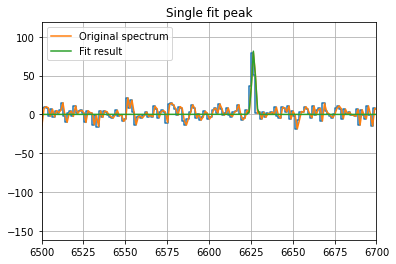

In [86]:
print(function(wavelength, (Flux75[:, 12842]), (Error75[:, 12842])))

In [42]:
amp75_array = np.zeros((HalphaImage).shape)
red75_array = np.zeros((HalphaImage).shape)
std75_array = np.zeros((HalphaImage).shape)
mean75_array = np.zeros((HalphaImage).shape)

for i in range(14321):
    amp75_array[(np.where(HalphaImage>=75))[0][i], (np.where(HalphaImage>=75))[1][i]] = amplitudes75[i]
    red75_array[(np.where(HalphaImage>=75))[0][i], (np.where(HalphaImage>=75))[1][i]] = red75[i]
    std75_array[(np.where(HalphaImage>=75))[0][i], (np.where(HalphaImage>=75))[1][i]] = stddev75[i]
    mean75_array[(np.where(HalphaImage>=75))[0][i], (np.where(HalphaImage>=75))[1][i]] = mean75[i]
    


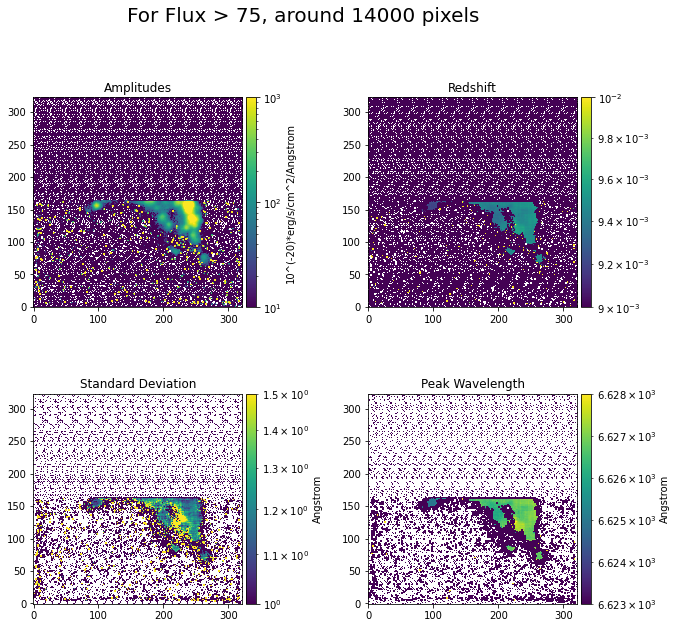

In [43]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig, axs = plt.subplots(2, 2, figsize = (10, 10))
fig.suptitle('For Flux > 75, around 14000 pixels', fontsize=20)
plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.2)

#-------------------------------------------------------------------------------------------
im1 = axs[0, 0].imshow(amp75_array,  origin='lower', norm=mpl.colors.LogNorm(vmin=10, vmax=1e3))
axs[0, 0].set_title('Amplitudes')

divider = make_axes_locatable(axs[0, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im1, cax=cax, orientation='vertical', label='10^(-20)*erg/s/cm^2/Angstrom')

#-------------------------------------------------------------------------------------------
im2 = axs[0, 1].imshow(red75_array,  origin='lower', norm=mpl.colors.LogNorm(vmin=0.0090, vmax=0.01))
axs[0, 1].set_title('Redshift')

divider = make_axes_locatable(axs[0, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im2, cax=cax, orientation='vertical');

#-------------------------------------------------------------------------------------------
im3 = axs[1, 0].imshow(std75_array,  origin='lower', norm=mpl.colors.LogNorm(vmin=1, vmax=1.5))
axs[1, 0].set_title('Standard Deviation')

divider = make_axes_locatable(axs[1, 0])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im3, cax=cax, orientation='vertical', label='Angstrom');

#-------------------------------------------------------------------------------------------
im4 = axs[1, 1].imshow(mean75_array,  origin='lower', norm=mpl.colors.LogNorm(vmin=6623, vmax=6628))
axs[1, 1].set_title('Peak Wavelength')

divider = make_axes_locatable(axs[1, 1])
cax = divider.append_axes('right', size='5%', pad=0.05)
fig.colorbar(im4, cax=cax, orientation='vertical', label='Angstrom');